# GMRF

In [1825]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter,MultipleLocator

import matplotlib
# del matplotlib.font_manager.weight_dict['roman']
#matplotlib.font_manager._rebuild() 

plt.rcParams['font.family'] = "Century" # Times New Romanだとフォントが埋め込みされない
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams["xtick.direction"] = 'in'
plt.rcParams["ytick.direction"] = 'in'

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [1826]:
import numpy as np
import math
import matplotlib.pyplot as plt

def mse(data1, data2):
    t = data1 - data2
    return np.dot(t, t) / len(data1)

def rmse(data1, data2):
    return math.sqrt(mse(data1, data2))

def plot_waves(x, y1, y2=None, labels=("Waveform 1", "Waveform 2"), title="Two Waveforms", xlabel="Time", ylabel="Amplitude"):
    """
    Plot two waveforms on the same figure.

    Parameters:
        x (array-like): The x-axis values (e.g., time points).
        y1 (array-like): The y-axis values for the first waveform.
        y2 (array-like): The y-axis values for the second waveform.
        labels (tuple): Labels for the waveforms, defaults to ("Waveform 1", "Waveform 2").
        title (str): The title of the plot.
        xlabel (str): Label for the x-axis.
        ylabel (str): Label for the y-axis.

    Returns:
        None
    """
    plt.figure(figsize=(6, 4))
    
    # Plot the first waveform
    plt.plot(x, y1, label=labels[0], color='black')
    
    # Plot the second waveform
    if y2 is not None:
        plt.plot(x, y2, label=labels[1], alpha=0.75)
    
    # Add labels and legend
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.ylim(-1, 1)
    plt.grid(True)
    
    # Show the plot
    plt.show()

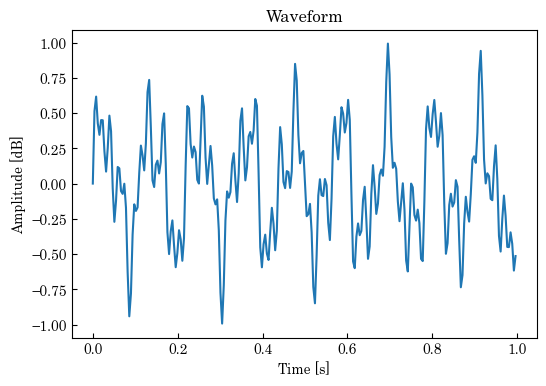

In [1827]:
import utills.preprocess as pp

fs = 256
dt = np.arange(0, 1, 1/fs)
# wave = 0.4*np.sin(9*dt*2*np.pi) + 0.3*np.sin(17*dt*2*np.pi) + 0.2*np.sin(23*dt*2*np.pi) + 0.1*np.sin(37*dt*2*np.pi)
# wave = 0.3*np.sin(9*dt*2*np.pi) + 0.3*np.sin(13*dt*2*np.pi) + 0.2*np.sin(23*dt*2*np.pi) + 0.2*np.sin(41*dt*2*np.pi)
# wave = 0.6*np.sin(9*dt*2*np.pi) + 0.4*np.sin(13*dt*2*np.pi)
# wave = 0.6*np.sin(4*dt*2*np.pi)+ 0.4*np.sin(18*dt*2*np.pi)
wave = 0.4*np.sin(9*dt*2*np.pi) + 0.2*np.sin(19*dt*2*np.pi) + 0.2*np.sin(32*dt*2*np.pi) + 0.2*np.sin(55*dt*2*np.pi)
pp.wave_plot(wave, fs=fs)

In [1828]:
mean = 0
stddev = [0.3, 0.4, 0.4]

cor_waves = [wave for i in range(len(stddev))]

rng = np.random.default_rng()

for i in range(len(stddev)):
    rand = rng.normal(mean, stddev[i], len(wave))
    cor_waves[i] = wave + rand
    cor_waves[i].clip(-1.0, 1.0)

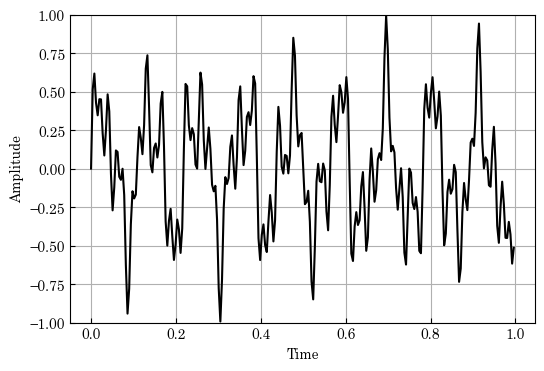

0.15138121368303148


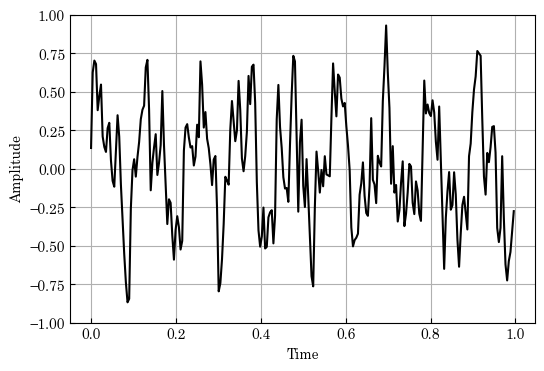

0.17060522258936067


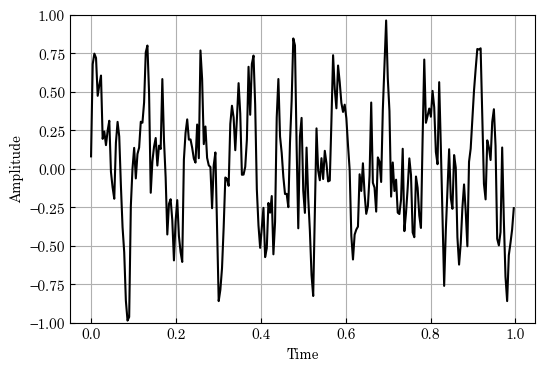

0.20888773555886547


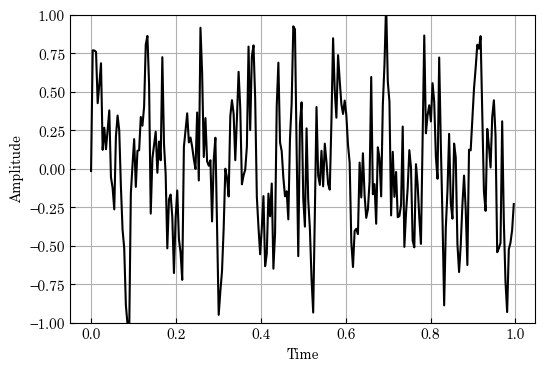

'\nfor cor in cor_waves:\n    plot_waves(x, cor, title=None)\n'

In [1829]:
from gmrf.x64.Release import gmrf

x = np.arange(0, 1, 1/fs)
plot_waves(x, wave, labels=('origin', 'None'), title=None)

g = gmrf.dvhgmrf.dvhgmrf()
g._alpha_rate = 1e-8
g._epoch = 1000
denoised_wave1 = g.denoise(cor_waves)
# print(g._epoch)
# print("分散 : ", g._sigma2)
print(rmse(wave, denoised_wave1))
plot_waves(x, denoised_wave1, labels=('DV-HGMRF', 'origin'), title=None)
dvhgmrf_rmse = rmse(wave, denoised_wave1)

g = gmrf.ivhgmrf.ivhgmrf()
g._alpha_rate = 1e-8
g._epoch = 1000
denoised_wave2 = g.denoise(cor_waves)
print(rmse(wave, denoised_wave2))
plot_waves(x, denoised_wave2, labels=('HGMRF', 'origin'), title=None)

g = gmrf.ivgmrf.ivgmrf()
g._alpha_rate = 1e-8
g._epoch = 1000
denoised_wave2 = g.denoise(cor_waves)
print(rmse(wave, denoised_wave2))
plot_waves(x, denoised_wave2, labels=('GMRF', 'origin'), title=None)

'''
for cor in cor_waves:
    plot_waves(x, cor, title=None)
'''

In [1830]:
import random

def gmrf_comparison(iter = 100):
    dvhgmrf_mses = []
    hgmrf_mses = []
    gmrf_mses = []

    for array_size in range(1, 11):
        dvhgmrf_mse, hgmrf_mse, gmrf_mse = 0, 0, 0
        # print(array_size)

        for _ in range(iter):
            # 一様乱数をarray_size個生成
            stddevs = [random.uniform(0.1, 0.5) for _ in range(array_size)]
            cor_waves = [wave for _ in range(array_size)]

            # 波形の劣化
            for i in range(array_size):
                rand = rng.normal(mean, stddevs[i], len(wave))
                cor_waves[i] = wave + rand
                cor_waves[i].clip(-1.0, 1.0)
            
            # 修復(dv-hgmrf)
            clock = 0
            while(clock<10):
                g = gmrf.dvhgmrf.dvhgmrf()
                g._alpha_rate = 1e-8
                g._epoch = 1000
                denoised_wave1 = g.denoise(cor_waves)
                if rmse(wave, denoised_wave1) < 1:
                    dvhgmrf_mse += rmse(wave, denoised_wave1)
                    break
                else:
                    clock += 1

            # 修復(hgmrf)
            clock = 0
            while(clock<10):
                g = gmrf.ivhgmrf.ivhgmrf()
                g._alpha_rate = 1e-8
                g._epoch = 1000
                denoised_wave2 = g.denoise(cor_waves)
                if rmse(wave, denoised_wave2) < 1:
                    hgmrf_mse += rmse(wave, denoised_wave2)
                    break
                else:
                    clock += 1

            # 修復(gmrf)
            g = gmrf.ivgmrf.ivgmrf()
            g._alpha_rate = 1e-8
            g._epoch = 1000
            denoised_wave3 = g.denoise(cor_waves)
            gmrf_mse += rmse(wave, denoised_wave3)

        dvhgmrf_mse /= iter
        hgmrf_mse /= iter
        gmrf_mse /= iter

        dvhgmrf_mses.append(dvhgmrf_mse)
        hgmrf_mses.append(hgmrf_mse)
        gmrf_mses.append(gmrf_mse)

    # グラフのプロット
    dvhgmrf_mses[0] = hgmrf_mses[0]
    x = np.arange(1,11)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6))

    # プロットする
    ax.plot(x, dvhgmrf_mses, label='proposed method', color="black", 
            linestyle='-', lw=1, marker='o', markersize=7, markerfacecolor='orange', zorder=2)
    ax.plot(x, hgmrf_mses, label='HGMRF', color="black", 
            linestyle='-', lw=1, marker='^', markersize=7, markerfacecolor='yellow', zorder=2)
    ax.plot(x, gmrf_mses, label='GMRF', color="black", 
            linestyle='-', lw=1, marker='s', markersize=7, markerfacecolor='blue', zorder=2)

    ax.legend(fontsize=23, loc='upper right', borderaxespad=0.5, framealpha=0)
    ax.set_xlabel('$\it{K}$', fontsize=25)
    ax.set_ylabel('RMSE', fontsize=25)
    ax.tick_params(labelsize=23)
    ax.grid(which='both', linestyle='')
    ax.tick_params(which='major', length=9, width=3) # 主目盛りの長さと太さ
    ax.tick_params(which='minor', length=5, width=2) # 補助目盛りの長さと太さ

    # 枠線の太さ
    ax.spines['top'].set_linewidth(3.3)
    ax.spines['right'].set_linewidth(3.3)
    ax.spines['left'].set_linewidth(3.3)
    ax.spines['bottom'].set_linewidth(3.3)

    ax.get_xaxis().set_tick_params(pad=13) # x軸目盛りを下にズらす
    ax.get_yaxis().set_tick_params(pad=13) # y軸目盛りを左にズラす

    plt.tight_layout()

    fig.savefig(f"comparison.eps", format="eps", dpi=300, bbox_inches='tight')

# gmrf_comparison()

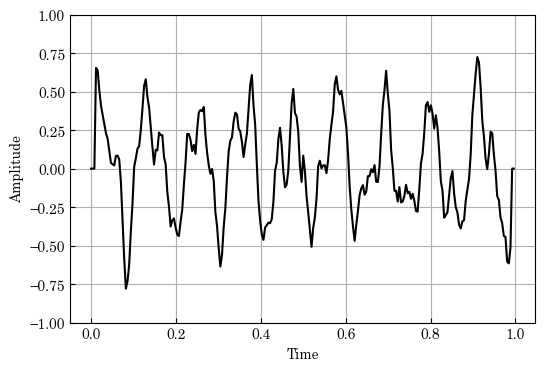

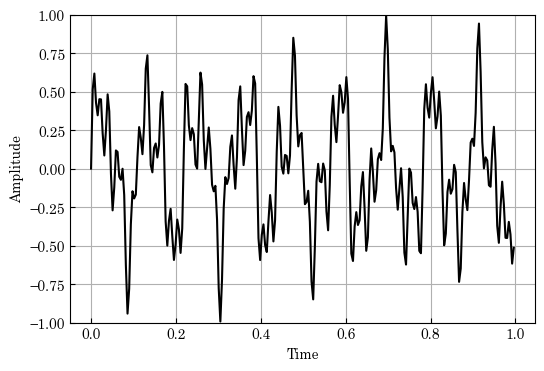

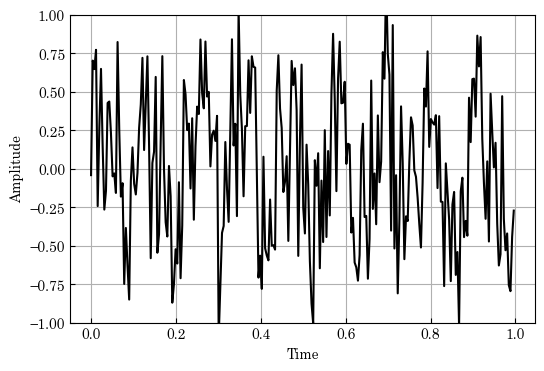

gaussian_filter : 0.21029508394037397


In [1831]:
# 平滑化フィルタ
def smoothing_filter(wave, kernel_size=None):
    # kernel_sizeが未入力または偶数ならアサート
    if kernel_size is None or kernel_size%2 == 0:
        assert(1)
    
    wave_size = len(wave)
    kernel = [1/kernel_size for _ in range(kernel_size)]

    filtered = np.zeros(wave_size)
    # 畳み込み
    for i in range(wave_size):
        if i <= kernel_size//2 or i > wave_size-(kernel_size//2)-1: continue
        for k in range(kernel_size):
            filtered[i] += wave[i + (k-(kernel_size//2))] * kernel[k]

    return filtered

filtered = smoothing_filter(np.mean(cor_waves, axis=0), kernel_size=5)
x = np.arange(0, 1, 1/fs)
plot_waves(x, filtered, title=None)
plot_waves(x, wave, title=None)
plot_waves(x, cor_waves[0], title=None)

print(f'gaussian_filter : {rmse(wave, filtered)}')

[0.26853285 0.17993572 0.21853768 0.25110951 0.25951486 0.26996152
 0.28719004]
0.1780334615905515


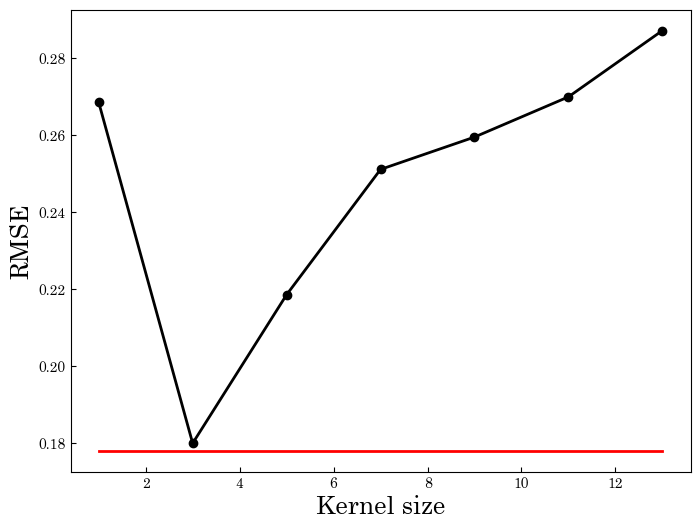

In [1832]:
max_kernel_size = 15
iter = 100
stddevs = [0.4, 0.5, 0.5]
n_kernels = (max_kernel_size-1)//2
rmse_for_smoothing = np.zeros(n_kernels)
rmse_for_dvhgmrf = 0

for i in range(iter):
    # 波形の劣化
    for i in range(len(stddevs)):
        rand = rng.normal(mean, stddevs[i], len(wave))
        cor_waves[i] = wave + rand
        cor_waves[i].clip(-1.0, 1.0)

    # 平滑化フィルタによるノイズ除去
    rmses = np.zeros(n_kernels)
    for i in range(n_kernels):
        filtered = smoothing_filter(np.mean(cor_waves, axis=0), kernel_size=(i*2+1))
        rmses[i] = rmse(wave, filtered)
    rmse_for_smoothing += rmses

    # 修復(dv-hgmrf)
    while(1):
        g = gmrf.dvhgmrf.dvhgmrf()
        g._alpha_rate = 1e-8
        g._epoch = 1000
        denoised_wave1 = g.denoise(cor_waves)
        if mse(wave, denoised_wave1) < 0.2:
            rmse_for_dvhgmrf += rmse(wave, denoised_wave1)
            break

rmse_for_smoothing /= iter
rmse_for_dvhgmrf /= iter

print(rmse_for_smoothing)
print(rmse_for_dvhgmrf)

x = np.arange(1, max_kernel_size, 2)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 6), sharey='all')
ax.plot(x, rmse_for_smoothing, color="black", linestyle='-', lw=2, marker='o')
ax.plot(x, [rmse_for_dvhgmrf for _ in range(n_kernels)], lw=2, color="red")
ax.set_xlabel("Kernel size", fontsize=18)
ax.set_ylabel("RMSE", fontsize=18)
plt.show()